# Home assignment 6

(deadline 27.02.2022 15:00 MSK)

Please, rename the Jupyter Notebook that you will submit as ```Surname_assignment6.ipynb```, where instead of ```Surname``` you write your family name. A solution of every problem should be placed below of the corresponding problem statement.

After the running commands (Kernel -> Restart & Run All) all cells in your file have to run correctly. Please check this before submission.

## Problem 1 (20 pts)

Consider the optimization problem from problem 3 in assignment 5. 
- (10 pts) Compare ADAM, SGD and accelerated gradient method that uses stochastic gradient estimation on this problem and discuss what method works better and why? 
- (5 pts) Illustrate your conclusion by convergence plots and test different strategies of step size selection. 
- (5 pts) Test different batch sizes and conclude the effect on gradient variance and convergence speed

**The optimization problem from problem 3 in assignment 5:**

- Consider the simple binary classification problem of data taken with [this utility](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html). So the first step in this problem is downlowding the dataset and derive matrix $X \in \mathbb{R}^{m \times n}$ of given data and vector $y \in \mathbb{R}^m$ of labels. 
- Now to train the simple logistic regression model you need to solve the following optimization problem

$$ -\frac{1}{m} \sum_{i=1}^m (y_i \log(h(w, b | x_i)) + (1 - y_i)\log(1 - h(w, b | x_i))) \to \min_{w, b},$$

where $y_i$ is an $i$-th label, $x_i$ is an $i$-th row of the matrix $X$, $h(w, b | x_i) = \sigma(w^{\top}x_i + b)$ (here we use $x_i$ as a column vector) and $\sigma(z) = \frac{1}{1 + e^{-z}}$. This problem has two parameter $w \in \mathbb{R}^n$ and $b \in \mathbb{R}$. It is possible to incorporate them in the single vector, so if you want, you can consider them as a components of the single vector.

In [75]:
# Your solution is here
from sklearn.datasets import load_breast_cancer
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import random
import warnings
import time

warnings.simplefilter("ignore")

dataset = load_breast_cancer()

In [76]:
X = np.array(dataset["data"])
y = np.array(dataset["target"])

# Scale and add free unit
X = MinMaxScaler().fit_transform(X)
X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
weights = np.random.rand(X.shape[1])

def sigm(X, W):
    return 1 / (1 + np.exp(- W @ X.T))

def log_loss(X, W, y):
    m = X.shape[0]
    return - 1/m * np.sum(y * np.log(sigm(W, X)) + (1 - y) * np.log(1 - sigm(W, X)))

def grad(X, W, y):
    m = X.shape[0]
    return 1/m * ((sigm(W, X) - y).T @ X)

def batch_grad(X, W, y, n):
    idxs = random.sample(list(range(X.shape[0])), n)
    X_batch = np.take(X, idxs, axis=0)
    y_batch = np.take(y, idxs)
    return grad(X_batch, W, y_batch)

def cost(X, W, y):
    return np.linalg.norm(grad(X, W, y))

In [70]:
# SGD

def sgd(X, W, y, alpha=1, batch_size=64, tol=1e-3, n_iter=10000):
    t0 = time.clock()
    history = []
    for i in range(n_iter):
        dw = batch_grad(X, W, y, batch_size)
        W -= alpha * dw
        err = cost(X, W, y)
        history.append(err)
        if err < tol:
            print(f"SGD: convergence achieved at the step number {i}, execution time: {time.clock() - t0}")
            return history
    print(f"SGD: reached the limit of steps: {n_iter}, execution time: {time.clock() - t0}")
    return history

In [71]:
# ADAM

def adam(X, W, y, alpha=1, batch_size=64, tol=1e-3, n_iter=10000):
    t0 = time.clock()
    b1, b2 = 0.9, 0.999 
    v_dw, m_dw = 0, 0
    eps = 1e-08
    eta = 0.01
    history = []
    for i in range(n_iter):
        dw = batch_grad(X, W, y, batch_size)

        # momentum beta 1
        m_dw = b1 * m_dw + (1 - b1) * dw
        # rms beta 2
        v_dw = b2 * v_dw + (1 - b2) * dw ** 2
        # bias correction
        m_dw_corr = m_dw / (1 - b1 ** batch_size)
        v_dw_corr = v_dw / (1 - b2 ** batch_size)
        h = eta * m_dw_corr / (eps + np.sqrt(v_dw_corr))

        W -= alpha * h
        err = cost(X, W, y)
        history.append(err)
        if err < tol:
            print(f"Adam: convergence achieved at the step number {i}, execution time: {time.clock() - t0}")
            return history
    print(f"Adam: reached the limit of steps: {n_iter}, execution time: {time.clock() - t0}")
    return history

In [72]:
# Accelerated gradient method

def agd(X, W, y, alpha=1, batch_size=64, tol=1e-3, n_iter=10000):
    t0 = time.clock()
    b = 0.5
    h = 0.9
    history = []
    for i in range(n_iter):
        h = b * h - alpha * batch_grad(X + alpha * h, W, y, batch_size)
        W += alpha * h

        err = cost(X, W, y)
        history.append(err)
        if err < tol:
            print(f"Adaptive GD: convergence achieved at the step number {i}, execution time: {time.clock() - t0}")
            return history
    print(f"Adaptive GD: reached the limit of steps: {n_iter}, execution time: {time.clock() - t0}")
    return history

\# Illustrate your conclusion by convergence plots and test different strategies of step size selection.

In [ ]:
a = 1
bs = 64
t = 1e-2
conv_history_adam = adam(X, np.copy(weights), y, alpha=a, batch_size=bs, tol=t)
conv_history_sgd = sgd(X, np.copy(weights), y, alpha=a, batch_size=bs, tol=t)
conv_history_agd = agd(X, np.copy(weights), y, alpha=a, batch_size=bs, tol=t)

Adam: convergence achieved at the step number 4506, execution time: 3.2728399999999738
SGD: convergence achieved at the step number 478, execution time: 0.309872999999925
Adaptive GD: convergence achieved at the step number 263, execution time: 0.2206220000000485


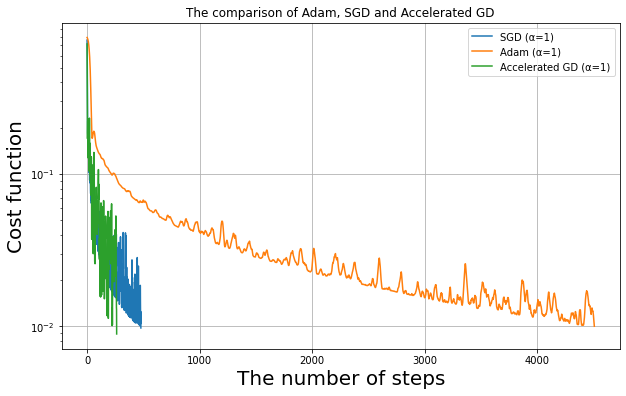

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel("The number of steps", fontsize=20)
plt.ylabel("Cost function", fontsize=20)
plt.grid(True)

plt.semilogy(conv_history_sgd, label=(f"SGD (α={a})"))
plt.semilogy(conv_history_adam, label=(f"Adam (α={a})"))
plt.semilogy(conv_history_agd, label=(f"Accelerated GD (α={a})"))

plt.title("The comparison of Adam, SGD and Accelerated GD")
plt.legend();

In [ ]:
a = 0.1
bs = 64
t = 1e-2
conv_history_adam = adam(X, np.copy(weights), y, alpha=a, batch_size=bs, tol=t)
conv_history_sgd = sgd(X, np.copy(weights), y, alpha=a, batch_size=bs, tol=t)
conv_history_agd = agd(X, np.copy(weights), y, alpha=a, batch_size=bs, tol=t)

Adam: reached the limit of steps: 10000, execution time: 7.086943000000019
SGD: convergence achieved at the step number 4578, execution time: 2.9659299999999575
Adaptive GD: reached the limit of steps: 10000, execution time: 7.4080659999999625


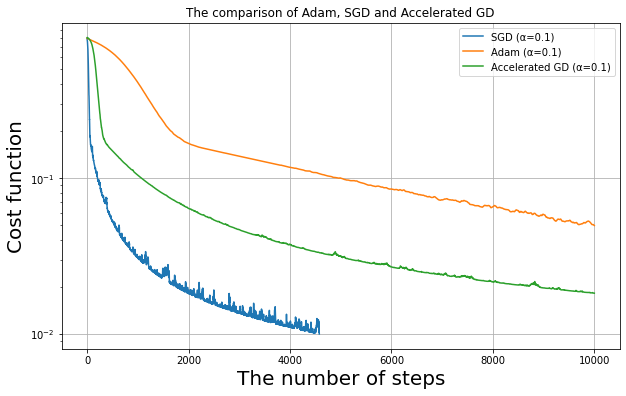

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel("The number of steps", fontsize=20)
plt.ylabel("Cost function", fontsize=20)
plt.grid(True)

plt.semilogy(conv_history_sgd, label=(f"SGD (α={a})"))
plt.semilogy(conv_history_adam, label=(f"Adam (α={a})"))
plt.semilogy(conv_history_agd, label=(f"Accelerated GD (α={a})"))

plt.title("The comparison of Adam, SGD and Accelerated GD")
plt.legend();

In [ ]:
a = 5
bs = 64
t = 1e-2
conv_history_adam = adam(X, np.copy(weights), y, alpha=a, batch_size=bs, tol=t)
conv_history_sgd = sgd(X, np.copy(weights), y, alpha=a, batch_size=bs, tol=t)
conv_history_agd = agd(X, np.copy(weights), y, alpha=a, batch_size=bs, tol=t)

Adam: convergence achieved at the step number 951, execution time: 0.6951159999999845
SGD: convergence achieved at the step number 91, execution time: 0.057935999999926935
Adaptive GD: reached the limit of steps: 10000, execution time: 7.301459000000023


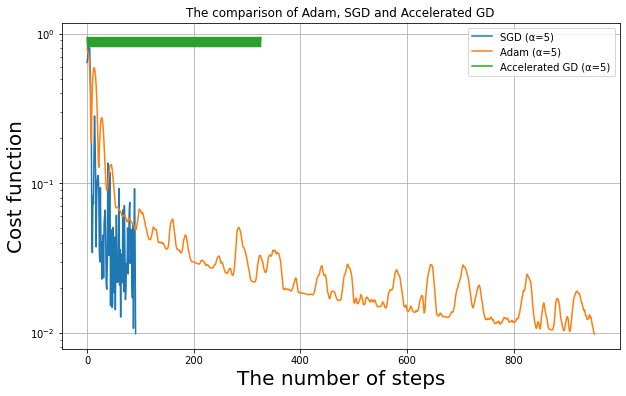

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel("The number of steps", fontsize=20)
plt.ylabel("Cost function", fontsize=20)
plt.grid(True)

plt.semilogy(conv_history_sgd, label=(f"SGD (α={a})"))
plt.semilogy(conv_history_adam, label=(f"Adam (α={a})"))
plt.semilogy(conv_history_agd, label=(f"Accelerated GD (α={a})"))

plt.title("The comparison of Adam, SGD and Accelerated GD")
plt.legend();

In [ ]:
a = 100
bs = 64
t = 1e-3
conv_history_adam = adam(X, np.copy(weights), y, alpha=a, batch_size=bs, tol=t)
conv_history_sgd = sgd(X, np.copy(weights), y, alpha=a, batch_size=bs, tol=t)
conv_history_agd = agd(X, np.copy(weights), y, alpha=a, batch_size=bs, tol=t)

Adam: convergence achieved at the step number 580, execution time: 0.4093680000000859
SGD: convergence achieved at the step number 7839, execution time: 5.180272999999943
Adaptive GD: reached the limit of steps: 10000, execution time: 7.261632000000077


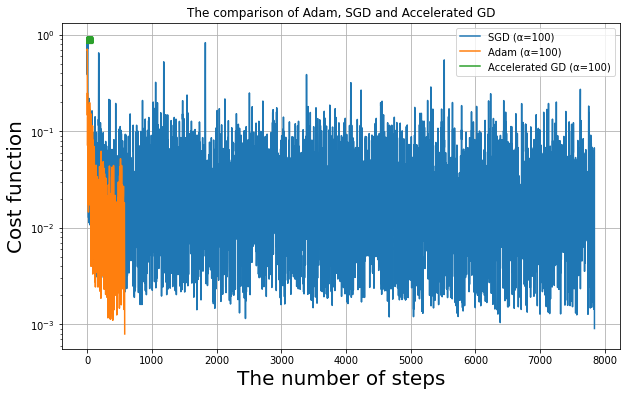

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel("The number of steps", fontsize=20)
plt.ylabel("Cost function", fontsize=20)
plt.grid(True)

plt.semilogy(conv_history_sgd, label=(f"SGD (α={a})"))
plt.semilogy(conv_history_adam, label=(f"Adam (α={a})"))
plt.semilogy(conv_history_agd, label=(f"Accelerated GD (α={a})"))

plt.title("The comparison of Adam, SGD and Accelerated GD")
plt.legend();

The first conclusion is that the rate of convergence of the methods covered above depends and there's no method being the fastest in all cases. The charts above show that all three methods may be the fastest depending on the initial learning_rate (alpha). 

The execution time mostly depends on the number of steps it tool a method to converge (considering all parameters are similar).

\# Test different batch sizes and conclude the effect on gradient variance and convergence speed

In [ ]:
a = 1
bs = 64
t = 5e-2
conv_history_sgd8 = sgd(X, np.copy(weights), y, alpha=a, batch_size=8, tol=t)
conv_history_sgd32 = sgd(X, np.copy(weights), y, alpha=a, batch_size=32, tol=t)
conv_history_sgd128 = sgd(X, np.copy(weights), y, alpha=a, batch_size=128, tol=t)
conv_history_full_batch_gd = adam(X, np.copy(weights), y, alpha=a, batch_size=X.shape[0], tol=t)

SGD: convergence achieved at the step number 54, execution time: 0.05986899999993511
SGD: convergence achieved at the step number 53, execution time: 0.04215899999996964
SGD: convergence achieved at the step number 56, execution time: 0.07611499999995885
Adam: convergence achieved at the step number 194, execution time: 0.8005940000000464


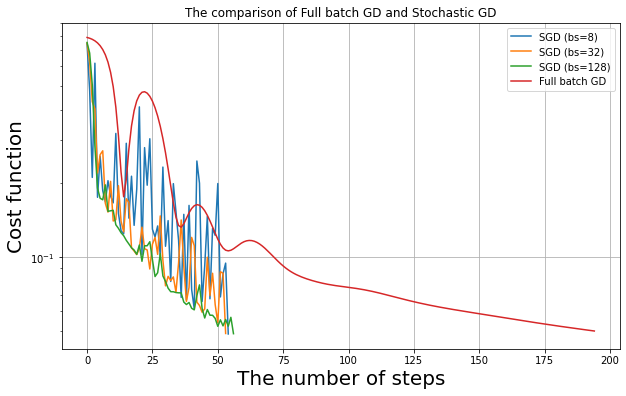

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel("The number of steps", fontsize=20)
plt.ylabel("Cost function", fontsize=20)
plt.grid(True)

plt.semilogy(conv_history_sgd8, label=(f"SGD (bs=8)"))
plt.semilogy(conv_history_sgd32, label=(f"SGD (bs=32)"))
plt.semilogy(conv_history_sgd128, label=(f"SGD (bs=128)"))
plt.semilogy(conv_history_full_batch_gd, label=(f"Full batch GD"))

plt.title("The comparison of Full batch GD and Stochastic GD")
plt.legend();

In [ ]:
a = 5
t = 1e-3
conv_history_sgd8 = sgd(X, np.copy(weights), y, alpha=a, batch_size=8, tol=t)
conv_history_sgd32 = sgd(X, np.copy(weights), y, alpha=a, batch_size=32, tol=t)
conv_history_sgd128 = sgd(X, np.copy(weights), y, alpha=a, batch_size=128, tol=t)
conv_history_full_batch_gd = sgd(X, np.copy(weights), y, alpha=a, batch_size=X.shape[0], tol=t)

SGD: convergence achieved at the step number 2555, execution time: 1.5035100000000057
SGD: convergence achieved at the step number 2284, execution time: 1.7946610000000192
SGD: convergence achieved at the step number 2161, execution time: 2.1077739999999494
SGD: convergence achieved at the step number 2059, execution time: 5.802118999999948


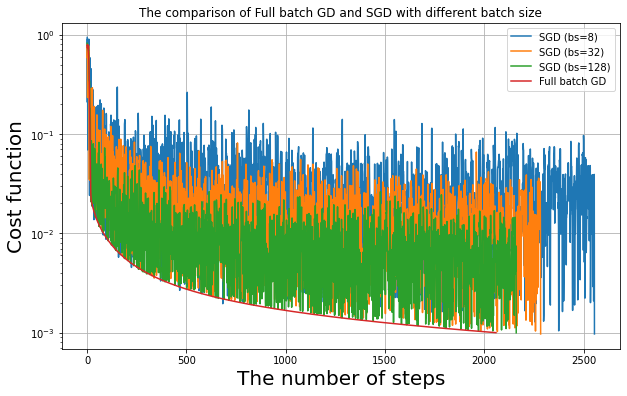

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel("The number of steps", fontsize=20)
plt.ylabel("Cost function", fontsize=20)
plt.grid(True)

plt.semilogy(conv_history_sgd8, label=(f"SGD (bs=8)"))
plt.semilogy(conv_history_sgd32, label=(f"SGD (bs=32)"))
plt.semilogy(conv_history_sgd128, label=(f"SGD (bs=128)"))
plt.semilogy(conv_history_full_batch_gd, label=(f"Full batch GD"))

plt.title("The comparison of Full batch GD and SGD with different batch size")
plt.legend();

The second conclusion is that there's no the most suitable batch size for "vanilla" gradient descent. Depending on the precision of the solution required, the algorithm may give the fastest convergence for different batch size:

* It takes less number of steps for SGD to converge in the case of low precision (high tolerance)
* But, if our problem requires low tolerance, we can see that the number of iterations has an inverse relationship with the size of batch (full batch GD converges in less number of iterations than SGD with 8 samples per step)
* The interestin point that even though it takes less number of steps in the second case for full batch GD to converge, the algorithm execution time is still lower for SGD (the lowest is for the lowest batch size).

So, we can make a general conclusion, that it is more likely for SGD to converge faster (in terms of time) than for the full batch GD, although it can take more iterations (depending on a problem).

In [ ]:
a = 100
t = 1e-3
conv_history_adam8 = adam(X, np.copy(weights), y, alpha=a, batch_size=8, tol=t)
conv_history_adam32 = adam(X, np.copy(weights), y, alpha=a, batch_size=32, tol=t)
conv_history_adam128 = adam(X, np.copy(weights), y, alpha=a, batch_size=128, tol=t)
conv_history_adam_fb = adam(X, np.copy(weights), y, alpha=a, batch_size=X.shape[0], tol=t)

Adam: convergence achieved at the step number 2103, execution time: 0.900131999999985
Adam: convergence achieved at the step number 831, execution time: 0.45769700000005287
Adam: convergence achieved at the step number 469, execution time: 0.4904190000000881
Adam: convergence achieved at the step number 154, execution time: 0.45020399999998517


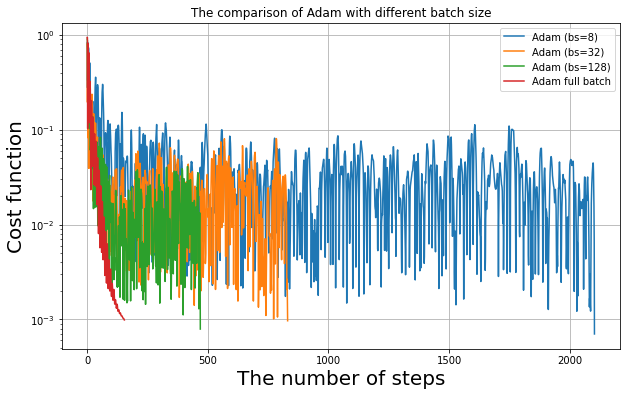

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel("The number of steps", fontsize=20)
plt.ylabel("Cost function", fontsize=20)
plt.grid(True)

plt.semilogy(conv_history_adam8, label=(f"Adam (bs=8)"))
plt.semilogy(conv_history_adam32, label=(f"Adam (bs=32)"))
plt.semilogy(conv_history_adam128, label=(f"Adam (bs=128)"))
plt.semilogy(conv_history_adam_fb, label=(f"Adam full batch"))

plt.title("The comparison of Adam with different batch size")
plt.legend();

For the case of adaptive momentum estimation algorithm we see that the higher batch size, the less time and iterations it takes to converge.

In [ ]:
a = 0.5
t = 1e-2
conv_history_agd8 = agd(X, np.copy(weights), y, alpha=a, batch_size=8, tol=t)
conv_history_agd32 = agd(X, np.copy(weights), y, alpha=a, batch_size=32, tol=t)
conv_history_agd128 = agd(X, np.copy(weights), y, alpha=a, batch_size=128, tol=t)
conv_history_agd_fb = agd(X, np.copy(weights), y, alpha=a, batch_size=X.shape[0], tol=t)

Adaptive GD: convergence achieved at the step number 916, execution time: 0.6334330000000818
Adaptive GD: convergence achieved at the step number 946, execution time: 0.8571749999999838
Adaptive GD: convergence achieved at the step number 938, execution time: 0.9715800000000172
Adaptive GD: convergence achieved at the step number 1127, execution time: 3.2495079999999916


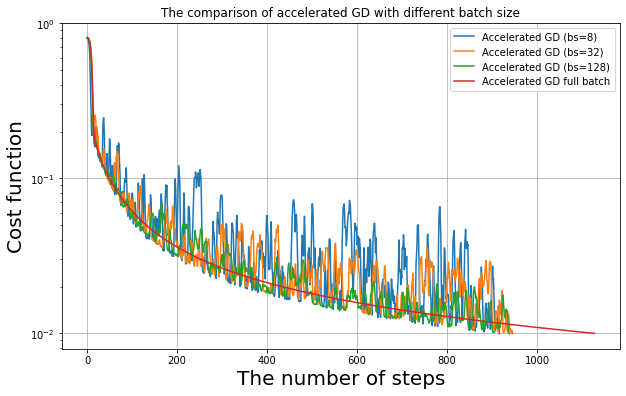

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel("The number of steps", fontsize=20)
plt.ylabel("Cost function", fontsize=20)
plt.grid(True)

plt.semilogy(conv_history_agd8, label=(f"Accelerated GD (bs=8)"))
plt.semilogy(conv_history_agd32, label=(f"Accelerated GD (bs=32)"))
plt.semilogy(conv_history_agd128, label=(f"Accelerated GD (bs=128)"))
plt.semilogy(conv_history_agd_fb, label=(f"Accelerated GD full batch"))

plt.title("The comparison of accelerated GD with different batch size")
plt.legend();

For the case of Nesterov accelerated GD the conclusion is similar to the "vanilla" gradient descent, i.e. the less batch size, the higher convergence both in terms of iterations and execution time.

\# Discuss what method works better and why?

First of all, there's no "best" method, because the performance always dependens on a particular problem. But we can conclude the following general points.

The most universal approach (rule of thumb) is to use Adam because of adaptive step size and higher consistency due to "momentum" effect. However, other methods may be more efficient depending on a problem and initial parameters, which is shown above.

## Problem 2 (8 pts)

Consider the following optimization problem

$$
\min_x \log \left( \sum_{i=1}^m \exp(a_i^{\top}x + b_i)\right).
$$

- (2 pts) Compare convergence of gradient descent, non-linear conjugate gradient method from ```scipy.optimize``` package, heavy ball method and accelerated gradient method in solving this problem if the gradient norm is used as a measure of convergence 

- (4 pts) What procedure to select the step size gives the fastest convergence for every method? Consider any three strategies for every of the following method: gradient descent, heavy ball method and accelerated gradient method. For example, constant, decreasing sequence, some adaptive rule. In the latter case, think how you can adapt the Armijo rule (or similar rules) for heavy ball and accelerated gradient method.
- (2 pts) Consider different dimensions $m$ and $n$ ($m > n$ and $m < n$). Vectors $a_i$ and $b$ can be generated from the standard normal distribution.

Note that the stable way to compute the objective and gradient is crucial to solve this problem successfully, otherwise you will get NaN values in vector $x_k$ since the intermediate values for the sum of large exponent overflow the capacity of the ```double``` precision.

$$f(x) = \log \left( \sum_{i=1}^m \exp(a_i^{\top}x + b_i)\right)$$

$$\nabla f(x) = \frac{\exp(a^{\top}x + b)a^{\top}}{\sum_{i=1}^m \exp(a_i^{\top}x + b_i)}$$

Compare convergence of gradient descent, non-linear conjugate gradient method from ```scipy.optimize``` package, heavy ball method and accelerated gradient method in solving this problem if the gradient norm is used as a measure of convergence 

In [ ]:
!pip install git+https://github.com/amkatrutsa/liboptpy

  Cloning https://github.com/amkatrutsa/liboptpy to /tmp/pip-req-build-344ui1wa
  Running command git clone -q https://github.com/amkatrutsa/liboptpy /tmp/pip-req-build-344ui1wa
  Created wheel for liboptpy: filename=liboptpy-0.0.1-py3-none-any.whl size=12866 sha256=b9182d6d5d694dfb4ae7c166fe5e5e268b69a40f1f9004c18d8b374a290fe2a6
  Stored in directory: /tmp/pip-ephem-wheel-cache-k94sc7y5/wheels/ab/74/bb/5e8e0b3a8bfb0f7217acf303a3d150d461d1b55f7d97519d7d
Successfully built liboptpy


In [ ]:
from scipy.optimize import minimize
# import liboptpy.unconstr_solvers as methods
# from liboptpy.unconstr_solvers.fo import GradientDescent, AcceleratedGD
from liboptpy.step_size import Backtracking, ConstantStepSize
from liboptpy.base_optimizer import LineSearchOptimizer

def func(W, x):
    return np.log(np.sum(np.exp(W.T @ X)))

def cost(W, x, y):
    return np.linalg.norm(grad(X, W, y))

def grad(W, x, y):
    return ((np.exp(W.T @ X) @ W.T) / (np.sum(np.exp(W.T @ X)))).T

m, n = 1000, 100
W = np.random.rand(m, n)
W = np.concatenate([W, np.ones((X.shape[0], 1))], axis=1)  # free unit
x = np.random.rand(W.shape[1])
y = func(W, x)

In [ ]:
# gradient descent

def gd(X, W, y, alpha=1, tol=1e-3, n_iter=10000):
    t0 = time.clock()
    history = []
    for i in range(n_iter):
        dw = grad(X, W, y)
        W -= alpha * dw
        err = cost(X, W, y)
        history.append(err)
        if err < tol:
            print(f"GD: convergence achieved at the step number {i}, execution time: {time.clock() - t0}")
            return history
    print(f"GD: reached the limit of steps: {n_iter}, execution time: {time.clock() - t0}")
    return history

In [ ]:
# non-linear conjugate gradient method from scipy.optimize
f = lambda ww: func(ww, x)
f_g = lambda ww: grad(ww, x, y)
minimize(f, W, method="Newton-CG", tol=1e-3, jac=f_g, options={'gtol': 1e-3, 'disp': True})

In [ ]:
# heavy ball method
W_eig = np.linalg.eigvals(W.T @ W)

mu = np.min(W_eig)
L =  np.max(W_eig)
alpha_opt = 4 / (np.sqrt(L) + np.sqrt(mu))**2
beta_opt = np.maximum((1 - np.sqrt(alpha_opt * L))**2, 
                      (1 - np.sqrt(alpha_opt * mu))**2)

class HeavyBall(LineSearchOptimizer):
    def __init__(self, f, grad, step_size, beta, **kwargs):
        super().__init__(f, grad, step_size, **kwargs)
        self._beta = beta
    
    def get_direction(self, x):
        self._current_grad = self._grad(x)
        return -self._current_grad

    def _f_update_x_next(self, x, alpha, h):
        if len(self.convergence) < 2:
            return x + alpha * h
        else:
            return x + alpha * h + self._beta * (x - self.convergence[-2])
    
    def get_stepsize(self):
        return self._step_size.get_stepsize(self._grad_mem[-1], 
                                            self.convergence[-1], 
                                            len(self.convergence))

hbgd = HeavyBall(lambda x_: func(x_, x), lambda x_: grad(x_, x, y), 
               ConstantStepSize(alpha_opt), beta=beta_opt)
Ww = hbgd.solve(W, tol=1e-3, max_iter=1000, disp=True)

hb_conv = hbgd.get_convergence()
hb_conv = [cost(Ww, x, y) for x in hb_conv]

Maximum iteration exceeds!
Convergence in 1000 iterations
Function value = nan
Norm of gradient = nan


In [ ]:
# accelerated gradient method

What procedure to select the step size gives the fastest convergence for every method?

Consider any three strategies for every of the following method: gradient descent, heavy ball method and accelerated gradient method. 

For example, constant, decreasing sequence, some adaptive rule. In the latter case, think how you can adapt the Armijo rule (or similar rules) for heavy ball and accelerated gradient method.

Consider different dimensions $m$ and $n$ ($m > n$ and $m < n$). Vectors $a_i$ and $b$ can be generated from the standard normal distribution.